In [ ]:
import demucs.api
from typing import List
import torch
import torchaudio
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
from datetime import timedelta
from typing import Optional, Tuple
import pandas as pd
import json

from data_processing.dataset_ingestion import ingest_audio_url, update_audio_titles
from data_processing.stem_split import stem_split_all_in_folder
from data_processing.audio_analysis import extract_longest_windows_above_threshold
from data_processing.audio_util import get_audio_length
from data_processing.data_pipeline import AudioPipeline, AudioExample

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
def ingest_csv_urls(url_csv_path: str, download_path: str) -> None:
    df = pd.read_csv(url_csv_path)
    df["url"].apply(lambda x: ingest_audio_url(x, download_path))

In [8]:
ingest_csv_urls("audio_dataset/youtube_urls.csv", "audio_dataset/download/")
update_audio_titles("audio_dataset/audio_metadata.csv", "audio_dataset/download/")

In [9]:
separator = demucs.api.Separator(
    model="htdemucs_6s", shifts=2, jobs=12, device=device, progress=True
)
stem_split_all_in_folder(
    "audio_dataset/download/",
    separator,
    "audio_dataset/shift2repeat2/",
    repeated_splits=2,
)

100%|██████████████████████████████████████████████| 327.59999999999997/327.59999999999997 [00:13<00:00, 23.80seconds/s]
100%|██████████████████████████████████████████████| 327.59999999999997/327.59999999999997 [00:13<00:00, 23.87seconds/s]
100%|██████████████████████████████████████████████| 327.59999999999997/327.59999999999997 [00:13<00:00, 23.92seconds/s]
100%|██████████████████████████████████████████████| 327.59999999999997/327.59999999999997 [00:13<00:00, 23.84seconds/s]
100%|██████████████████████████████████████████████| 327.59999999999997/327.59999999999997 [00:13<00:00, 23.81seconds/s]
100%|██████████████████████████████████████████████| 327.59999999999997/327.59999999999997 [00:13<00:00, 23.75seconds/s]
100%|██████████████████████████████████████████████████████████████████████| 906.75/906.75 [00:38<00:00, 23.58seconds/s]
100%|██████████████████████████████████████████████████████████████████████| 906.75/906.75 [00:38<00:00, 23.58seconds/s]
100%|███████████████████████████

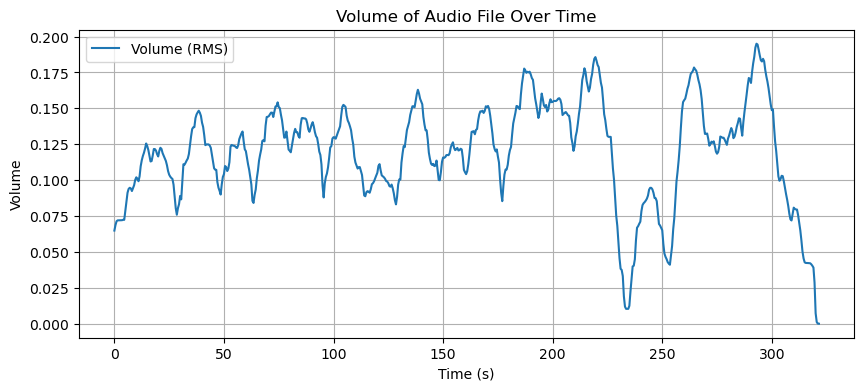

In [15]:
def plot_volume(
    audio_file_path: str, interval: Optional[Tuple[timedelta, timedelta]] = None
):
    waveform, sample_rate = torchaudio.load(audio_file_path)
    assert (waveform.dim() == 2) and (waveform.shape[0] == 1), "audio must be mono"

    frame_length = 32000 * 10
    hop_length = int(32000 * 0.5)
    padding = frame_length - hop_length
    waveform = F.pad(waveform, (padding // 2, padding - padding // 2))
    rms_over_time = torch.sqrt(
        F.avg_pool1d(waveform**2, kernel_size=frame_length, stride=hop_length)
    )
    
    time_axis = torch.arange(rms_over_time.shape[1]) * hop_length / sample_rate

    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, rms_over_time[0], label="Volume (RMS)")
    if interval is not None:
        start, end = interval[0].seconds, interval[1].seconds
        plt.xlim(start, end)
    plt.xlabel("Time (s)")
    plt.ylabel("Volume")
    plt.title("Volume of Audio File Over Time")
    plt.legend()
    plt.grid()
    plt.show()

plot_volume("audio_dataset/stem_split/sax_-lI-IqSxCHo.wav")

### Update metadata csv

In [8]:
def update_valid_windows(
    audio_metadata_csv_path: str, stem_split_folder: str, **kwargs
):
    df = pd.read_csv(audio_metadata_csv_path)
    df["valid_windows"] = df["video_id"].apply(
        lambda x: json.dumps(
            extract_longest_windows_above_threshold(
                os.path.join(stem_split_folder, f"sax_{x}.wav"), **kwargs
            ),
        )
    )
    return df


def update_audio_lengths(audio_metadata_csv_path: str, download_folder: str):
    df = pd.read_csv(audio_metadata_csv_path)
    df["audio_length"] = df["video_id"].apply(
        lambda x: round(
            get_audio_length(os.path.join(download_folder, f"{x}.wav")), ndigits=3
        )
    )
    return df


update_audio_titles("audio_dataset/audio_metadata.csv", "audio_dataset/download/")

update_valid_windows(
    "audio_dataset/audio_metadata.csv",
    "audio_dataset/shift2repeat2/",
    rms_threshold=0.0175,
).to_csv("audio_dataset/audio_metadata.csv", index=False)

update_audio_lengths(
    "audio_dataset/audio_metadata.csv", "audio_dataset/download/"
).to_csv(
    "audio_dataset/audio_metadata.csv", index=False
)

### Run audio pipeline

In [ ]:
def run_audio_pipeline():
    audio_metadata = pd.read_csv("audio_dataset/audio_metadata.csv")
    pipeline = AudioPipeline(num_pitch_augs=2, pitch_step_size=3, tempo_ratios={0.8, 1.25})
    augmented_clips: List[AudioExample] = []
    for video_id, video_title in zip(
        audio_metadata["video_id"], audio_metadata["video_title"]
    ):
        print(video_id, video_title)
        example = AudioExample(
            video_id,
            f"audio_dataset/shift2repeat2/sax_{video_id}.wav",
            f"audio_dataset/shift2repeat2/rhythm_{video_id}.wav",
            title=video_title,
        )
        augmented_clips.extend(pipeline(example))
    return augmented_clips

In [ ]:
augmented_clips = run_audio_pipeline()
torch.save(augmented_clips, "audio_dataset/augmented_audio.pt")

-lI-IqSxCHo Dexter Gordon - I Guess I'll Hang My Tears Out To Dry
-mZ54FJ6h-k John Coltrane - Impressions (Complete)
-wfjv70e6PE Summertime (Bonus Track)
-wLIfrdkzeM It's Easy To Remember (Take 7)
-YbgB5stEb4 It's Easy To Remember (Take 11)
03juO5oS2gg John Coltrane Quartet - Impressions.
0GpoOLJvlIw Art Pepper Quartet - I Surrender Dear
2HuEnifm23w All Or Nothing At All (Take 2)
2R0FHWXycPs Stan Getz Quartet - The Lady in Red
2r6ust9UrkY Big Nick (Bonus Track)
3Pmif4QeEg0 Art Pepper - Straight Life (Official Visualizer)
3RShrYcbCxs Art Pepper - Waltz Me Blues (Official Visualizer)
4UWEokROFq0 Nancy (With the Laughing Face)
4WJs17NZsgU Wabash
4yp4EybwaI4 In Your Own Sweet Way
5eHMr2k2faE Nancy
61jU-SHZGtE Art Pepper Quartet - Blues at Twilight
6pV87x6vId0 Stan Getz Quartet - Wrap Your Troubles in Dreams
6r-X7L-1CVs Stan Getz Bop Stars - Crazy Chords
76F4bvPBPBw Stan Getz Quartet - My Old Flame
7dvYY6p5T2s It's Easy To Remember (Take 9)
7kV9YWFTdi8 Art Pepper - Red Pepper Blues (Officia

In [ ]:
out: list[AudioExample] = torch.load("audio_dataset/augmented_audio.pt", map_location="cpu")